In [64]:
import uncertainties.umath as umath
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate 
import pandas as pd
from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import re


def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def monte_carlo_error(func, values, errors, n_samples=10000):
    samples = []
    for val, err in zip(values, errors):
        samples.append(np.random.normal(val, err, n_samples))
    
    results = func(*samples) 
    return np.mean(results), np.std(results)

c = 299792458
N_A = 6.02214076e+23
eV = 1.602176634e-19

E_S = 0.229e6

In [65]:
#During Experiment Confucsions
p_0 = 101.325e+3
T_0 = 273.15
T = T_0 + 23


def p(x,x_0):
    return (x/x_0)*p_0*(T/T_0)

print(p(40e-3,38e-3))

115638.79013844329


Kinetic Energies [5544223.42533201 5511574.55409507 5485671.80504745 5442972.58850806
 5388344.73317035]
Kinetic Energies peak [5485671.80504745 5442972.58850806 5388344.73317035]


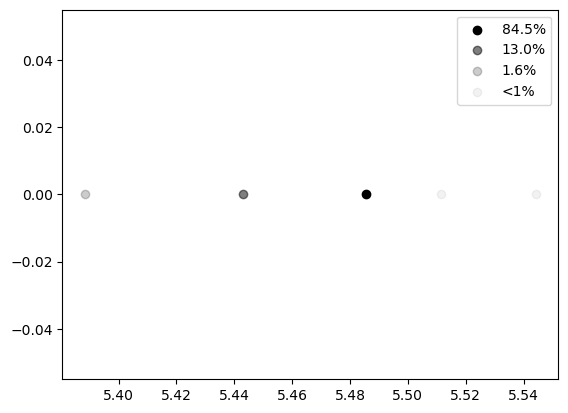

In [66]:
# 5.1.1 Kinetic Energy of alpha-particles

ex_energies0 =np.array([0,33.2,59.54,102.96,158.51])*10**3 #eV
ex_energies1 =np.array([59.54,102.96,158.51])*10**3 #eV
m_alpha = 6.6446263999e-27 #kg
m_np = 3.93627707875324e-25 #kg
m_np_u = 237.048167253 # u 
m_am = 4.00284236671118e-25 #kg
m_am_u = 241.056822944 # u 
m_he = 6.646478481946e-27 #kg
m_he_u = 4.002603250 #u
m_e = 9.1093837e-31 #kg
q_0 = c**2 * (m_am - m_np - m_he) / eV

def kinetic_energy(E_i): #eV
    return (q_0-E_i)/(1+m_alpha/m_np)

plt.scatter(kinetic_energy(ex_energies1[0])*1e-6,[0], label = '84.5%', color = 'black')
plt.scatter(kinetic_energy(ex_energies1[1])*1e-6,[0], label = '13.0%', color = 'black', alpha = 0.5)
plt.scatter(kinetic_energy(ex_energies1[2])*1e-6,[0], label = '1.6%', color = 'black', alpha = 0.2)


ex_energies =np.array([0,33.2])*10**3 #eV
plt.scatter(kinetic_energy(ex_energies)*1e-6,[0,0],label = '<1%', color = 'black',alpha = 0.05)
plt.legend()

kin_E = kinetic_energy(ex_energies0)
kin_E_peak = kinetic_energy(ex_energies1)
print('Kinetic Energies', kin_E) # eV
print('Kinetic Energies peak', kin_E_peak) # eV

In [67]:
# 5.1.2.1 Specific Energy Loss

epsilon_squared = 1.44e-9 #eV*m
# Material names
# Test Site 2 Foils - Filtered from complete dataset
materials = ["Al", "Al", "Cu", "Co", "Au"]
positions = [2, 3, 4, 5, 7, 8]

# Material properties from Bethe-Bloch table
I = [176.3, 176.3, 385.3, 334.7, 1084.4]  # Material I [eV]
K = [0.198, 0.198, -0.540, -0.614, -1.064]
Eu_eV = [1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.5e6]  # Eu [eV]
rel_uncertainty = [2, 2, 1, 2, 1]  # Relative Uncertainty [%]
atomic_Z = np.array([13, 13, 29, 27, 79])  # Atomic numbers

# Foil properties from Test Site 2 table
rho_g_cm3 = [2.70e-3, 2.70e-3, 8.92e-3, 8.90e-3, 19.32e-3]  # Density [g/cm³]
N_10_22_cm3 = [6.03, 6.03, 8.45, 9.09, 5.91]  # Atomic density [10²² atoms/cm³]

# Converted to standard SI units
rho_kg_m3 = [2700, 2700, 8920, 8900, 19320]  # Density [kg/m³]
N_m3 = np.array([6.03e28, 6.03e28, 8.45e28, 9.09e28, 5.91e28])  # Atomic density [atoms/m³]

m_T = m_alpha
z = 2
N_e = N_m3*atomic_Z # In standard units


def stopping(N_e,K,I,E_T):
    result = (2*np.pi*z**2 * epsilon_squared**2 *m_T *N_e*np.log((4*E_T*m_e)/(I*m_T) - K))/(E_T*m_e) 
    return result
    
#def stopping_cross_section_alt(E_alpha_MeV, Z, I_eV, K):
#    result = (3.80 / E_alpha_MeV) * Z * np.log((548.58 * E_alpha_MeV) / I_eV - K)* 1e-19 *N_air
#    return result


In [68]:
# STOPPING POWER MONTECARLO

import re
import numpy as np

# Read the file
filename = 'SRIM-2013/SRIM Outputs/Helium in  Air (gas).txt'
with open(filename, 'r') as f:
    lines = f.readlines()

# Initialize lists
energies = []
elec_stopping = []
nuclear_stopping = []

# Pattern to match data rows (e.g., "  5.50 MeV   7.161E-01  4.686E-04")
# Handles both keV and MeV entries
pattern = re.compile(
    r'\s*([\d.]+)\s+(?:keV|MeV)\s+([\d.E+-]+)\s+([\d.E+-]+)'
)

for line in lines:
    # Look for data rows containing keV or MeV
    if 'keV' in line or 'MeV' in line:
        # Clean line: replace multiple spaces with single space
        cleaned = ' '.join(line.split())
        # Now match: number, unit, elec, nuclear
        match = re.search(r'^([\d.]+)\s+(keV|MeV)\s+([\d.E+-]+)\s+([\d.E+-]+)', cleaned)
        
        if match:
            value = float(match.group(1))
            unit = match.group(2)
            elec = float(match.group(3))
            nuclear = float(match.group(4))
            
            # Convert energy to MeV
            if unit == 'keV':
                energy_mev = value / 1000.0
            else:  # MeV
                energy_mev = value
            
            energies.append(energy_mev)
            elec_stopping.append(elec)
            nuclear_stopping.append(nuclear)

# Convert to numpy arrays
energies_array = np.array(energies)
elec_stopping_array = np.array(elec_stopping)
nuclear_stopping_array = np.array(nuclear_stopping)

# Total stopping power (electronic + nuclear)
total_stopping_array = elec_stopping_array + nuclear_stopping_array

# Print results
print(f"Energies (MeV): {energies_array}")
print(f"Electronic stopping power: {elec_stopping_array}")
print(f"Nuclear stopping power: {nuclear_stopping_array}")
print(f"Total stopping power: {total_stopping_array}")

# Optionally, find closest energy to 5.5 MeV (Americium α)
if energies_array.size > 0:
    idx = np.abs(energies_array - 5.5).argmin()
    print(f"\nClosest to 5.5 MeV:")
    print(f"  Energy = {energies_array[idx]} MeV")
    print(f"  Elec. dE/dx = {elec_stopping_array[idx]} MeV/(mg/cm²)")
    print(f"  Nuclear dE/dx = {nuclear_stopping_array[idx]} MeV/(mg/cm²)")
    print(f"  Total dE/dx = {total_stopping_array[idx]} MeV/(mg/cm²)")


def convert_stopping_power(dE_dx_mass, rho=1.225):
    # Convert to linear stopping power in MeV/cm
    dE_dx_MeV_per_cm = dE_dx_mass * rho
    
    # Convert to eV/m
    dE_dx_eV_per_m = dE_dx_MeV_per_cm * 1e8  # 1e6 eV/MeV × 100 cm/m = 1e8
    
    return dE_dx_eV_per_m

Energies (MeV): [0.01   0.011  0.012  0.013  0.014  0.015  0.016  0.017  0.018  0.02
 0.0225 0.025  0.0275 0.03   0.0325 0.035  0.0375 0.04   0.045  0.05
 0.055  0.06   0.065  0.07   0.08   0.09   0.1    0.11   0.12   0.13
 0.14   0.15   0.16   0.17   0.18   0.2    0.225  0.25   0.275  0.3
 0.325  0.35   0.375  0.4    0.45   0.5    0.55   0.6    0.65   0.7
 0.8    0.9    1.     1.1    1.2    1.3    1.4    1.5    1.6    1.7
 1.8    2.     2.25   2.5    2.75   3.     3.25   3.5    3.75   4.
 4.5    5.     5.5    6.    ]
Electronic stopping power: [0.3148 0.3302 0.3449 0.3589 0.3725 0.3856 0.3982 0.4105 0.4224 0.4452
 0.4723 0.4979 0.5222 0.5454 0.5678 0.5892 0.61   0.63   0.6683 0.7045
 0.7389 0.7717 0.8032 0.8334 0.8905 0.9438 0.9938 1.041  1.086  1.128
 1.168  1.207  1.244  1.279  1.313  1.377  1.451  1.518  1.578  1.633
 1.683  1.728  1.768  1.803  1.863  1.908  1.94   1.961  1.972  1.975
 1.961  1.928  1.883  1.83   1.774  1.717  1.661  1.607  1.555  1.505
 1.459  1.374  1.281  1.202

a_i_atomic: [0.78476305 0.21056334 0.0046736 ]


C:\Users\Nikita\AppData\Local\Temp\ipykernel_13844\3183760731.py:30: RuntimeWarning: invalid value encountered in log
  result = (2*np.pi*z**2 * epsilon_squared**2 *m_T *N_e*np.log((4*E_T*m_e)/(I*m_T) - K))/(E_T*m_e)


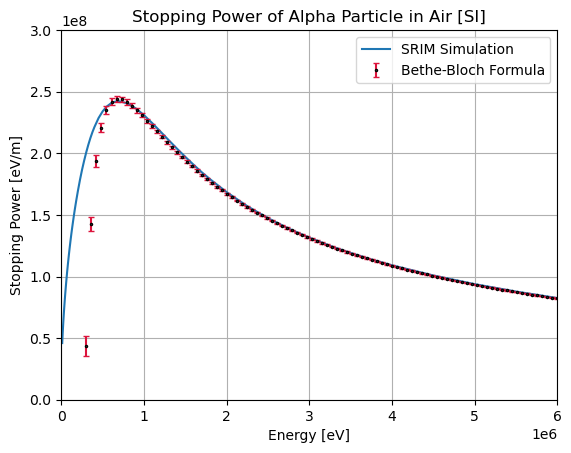

In [69]:
# 5.1.2.1 Stopping Power of Air




elements = ["Nitrogen", "Oxygen", "Argon"]
Z_i = np.array([7, 8, 18])
M_i = np.array([14.01e-3, 16e-3,39.95e-3])#kg/mol
a_i = [0.7808, 0.2095, 0.0093]
a_inter1 = np.array([2*a_i[0]/a_i[2], 2*a_i[1]/a_i[2], a_i[2]/a_i[2]])
a_i_atomic = a_inter1/np.sum(a_inter1)    # Fraction of atoms (for Bragg's rule)
print('a_i_atomic:',a_i_atomic)

K_eff = 0.650 
I_eff = 95.0 # eV
Z_eff = np.sum(Z_i * a_i_atomic) 
M_eff = np.sum(M_i * a_i_atomic) #kg/mol
air_density = 1.2250 #kg/m^3
N_air = air_density * N_A / M_eff
N_e_air = Z_eff*N_air



energy_array = np.linspace(1,6000000,100)#eV
#energy_array = np.linspace(1,5,10)#MeV

N_e_air_err = 0
K_eff_err = K_eff * 0.01
I_eff_err = I_eff * 0.01
energy_array_err = 0

plt.figure()
plt.title('Stopping Power of Alpha Particle in Air [SI]')
#plt.plot(energy_array,stopping(N_e_air,K_eff,I_eff,energy_array))
plt.xlabel('Energy [eV]')
plt.ylabel('Stopping Power [eV/m]')
plt.grid()

mean_air = np.zeros(len(energy_array))
std_air = np.zeros(len(energy_array))

for j in range(len(mean_air)):
    mean_air[j], std_air[j] = monte_carlo_error(stopping, [N_e_air,K_eff,I_eff,energy_array[j]],[N_e_air_err,K_eff_err,I_eff_err,energy_array_err])
plt.plot(energies_array*10**6,convert_stopping_power(elec_stopping_array+nuclear_stopping_array),label='SRIM Simulation')

plt.errorbar(energy_array,mean_air, yerr=std_air, fmt='o',ecolor = 'crimson', markersize=1.5,markeredgecolor='black', color = 'gray', capsize=2,label = 'Bethe-Bloch Formula')
plt.ylim(0,0.3e9)
plt.xlim(0,6e6)
plt.legend()

plt.savefig('air_stop_err.png')


C:\Users\Nikita\AppData\Local\Temp\ipykernel_13844\3183760731.py:30: RuntimeWarning: invalid value encountered in log
  result = (2*np.pi*z**2 * epsilon_squared**2 *m_T *N_e*np.log((4*E_T*m_e)/(I*m_T) - K))/(E_T*m_e)


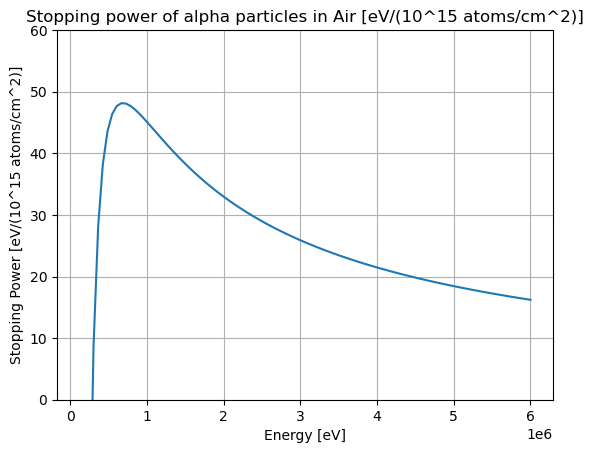

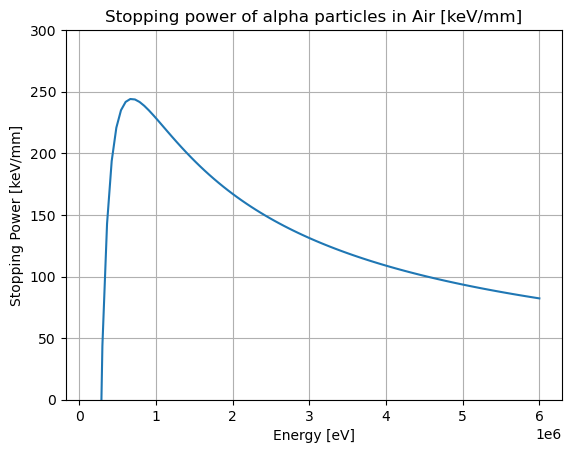

In [70]:
#Unit conversions Air

def S_15atomcm2(S,N):
    return S/N * 10000* 10**15

def S_keVmm(S):
    return S*1e-6

plt.figure()
plt.title('Stopping power of alpha particles in Air [eV/(10^15 atoms/cm^2)]')
plt.plot(energy_array,S_15atomcm2(stopping(N_e_air,K_eff,I_eff,energy_array),N_air))
plt.xlabel('Energy [eV]')
plt.ylabel('Stopping Power [eV/(10^15 atoms/cm^2)]')
plt.ylim(0,60)
plt.savefig('air_stop_cm.png')
plt.grid()


plt.figure()
plt.title('Stopping power of alpha particles in Air [keV/mm]')
plt.plot(energy_array,S_keVmm(stopping(N_e_air,K_eff,I_eff,energy_array)))
plt.xlabel('Energy [eV]')
plt.ylabel('Stopping Power [keV/mm]')
plt.ylim(0,300)
plt.savefig('air_stop_mm.png')
plt.grid()

Kinetic Energy Value [5485671.80504745 5442972.58850806 5388344.73317035]
Peak Position: [7658309.87868188 7603782.81850859 7528423.50975147]
Peak Width: [45314.35055189 50781.71984875 75427.80941849]
Peak Height: [265.74436395  73.04651103  12.13984772]
Peak Volume [12042033.26513774  3709427.45909023   915682.12027509]
Abundance [0.72250135 0.22255929 0.05493936]
Fit Coefficients [ 1.39672249 52.62830712]
Fit Error [6.91454893e-04 3.25705357e+03]
10690277.089496026


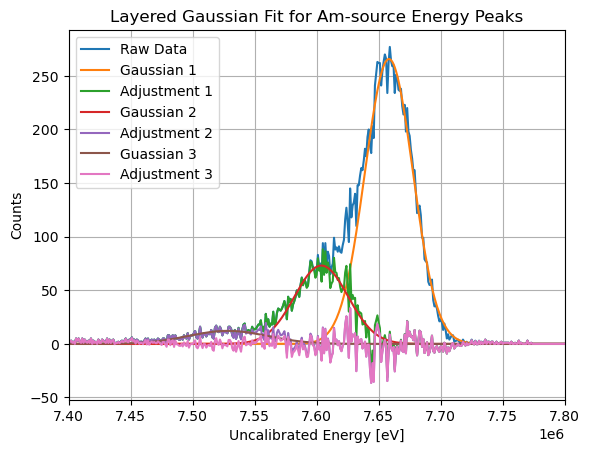

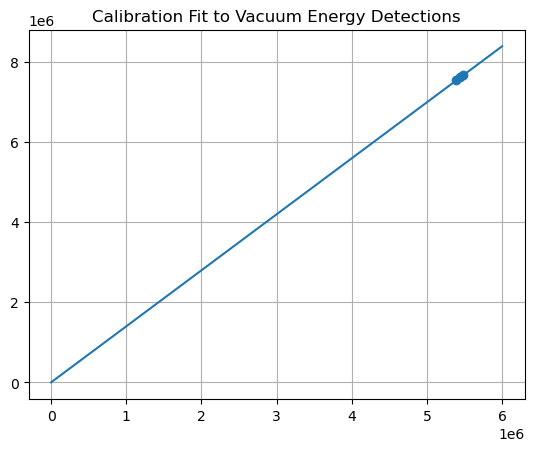

In [71]:
### 5.2 Calibration

peak_pos_cal = np.zeros(3)
peak_wid_cal = np.zeros(3)
peak_height_cal = np.zeros(3)
peak_volume_cal = np.zeros(3)
abundance_cal = np.zeros(3)


# Read with column names
df = pd.read_csv('Data/Calilbration27.10.txt',  sep=r'\s+', header=None)

# Access columns
energy_arr_cal = df[0].to_numpy()  # First column
energy_arr_cal *= 1000
count_arr_cal = df[1].to_numpy()  # Second column

plt.figure()
plt.title('Layered Gaussian Fit for Am-source Energy Peaks')
plt.xlabel('Uncalibrated Energy [eV]')
plt.ylabel('Counts')
plt.xlim(7400*1e+3,7800*1e+3)
plt.plot(energy_arr_cal,count_arr_cal, label = 'Raw Data')

initial_guess1 = np.array([250,7700,50])*10**3


#Guassian fit params
params, _ = curve_fit(gaussian, energy_arr_cal[7650:], count_arr_cal[7650:], p0=initial_guess1)
amplitude_cal, mean_cal, stddev_cal = params
fwhm_cal = 2 * np.sqrt(2 * np.log(2)) * stddev_cal  
peak_pos_cal[0] = mean_cal
peak_wid_cal[0] = fwhm_cal
peak_height_cal[0] = amplitude_cal
fit_cal1 = gaussian(energy_arr_cal, amplitude_cal, mean_cal, stddev_cal)

plt.plot(energy_arr_cal,fit_cal1,label = 'Gaussian 1')

adj1 = count_arr_cal - fit_cal1

plt.plot(energy_arr_cal,adj1, label = 'Adjustment 1')


initial_guess2 = np.array([50,7600,10])*10**3

params, _ = curve_fit(gaussian, energy_arr_cal[7570:], adj1[7570:], p0=initial_guess2)
amplitude_cal, mean_cal, stddev_cal = params
fwhm_cal = 2 * np.sqrt(2 * np.log(2)) * stddev_cal    
peak_pos_cal[1] = mean_cal
peak_wid_cal[1] = fwhm_cal
peak_height_cal[1] = amplitude_cal
fit_cal2 = gaussian(energy_arr_cal, amplitude_cal, mean_cal, stddev_cal)

plt.plot(energy_arr_cal,fit_cal2,label = 'Gaussian 2')

adj2 = adj1 - fit_cal2

plt.plot(energy_arr_cal,adj2, label = 'Adjustment 2')


initial_guess3 = np.array([50,7550,10])*10**3

params, _ = curve_fit(gaussian, energy_arr_cal[7450:], adj2[7450:], p0=initial_guess3)
amplitude_cal, mean_cal, stddev_cal = params
fwhm_cal = 2 * np.sqrt(2 * np.log(2)) * stddev_cal    
peak_pos_cal[2] = mean_cal
peak_wid_cal[2] = fwhm_cal
peak_height_cal[2] = amplitude_cal
fit_cal3 = gaussian(energy_arr_cal, amplitude_cal, mean_cal, stddev_cal)

plt.plot(energy_arr_cal,fit_cal3,label = 'Guassian 3')

adj3 = adj2 - fit_cal3

plt.plot(energy_arr_cal,adj3, label = 'Adjustment 3')



plt.legend()
plt.grid()

plt.savefig('alpha_layered.png')

print('Kinetic Energy Value', kin_E_peak)
print('Peak Position:', peak_pos_cal)
print('Peak Width:', peak_wid_cal)
print('Peak Height:', peak_height_cal)
print('Peak Volume', peak_height_cal*peak_wid_cal)
print('Abundance', peak_height_cal*peak_wid_cal / np.sum(peak_height_cal*peak_wid_cal))


#CALIBRATION:

plt.figure()
plt.scatter(kin_E_peak,peak_pos_cal)
c_overfit, c_cov = np.polyfit(np.append(kin_E_peak, 0),np.append(peak_pos_cal, 0),1, cov = True)

plt.title('Calibration Fit to Vacuum Energy Detections')
plt.grid()

print('Fit Coefficients',c_overfit)
print('Fit Error',np.sqrt(np.diag(c_cov)))
x= np.linspace(0,6000000,6001)
plt.plot(x,c_overfit[0]*x+c_overfit[1])

def calibrate(x):#keV -> eV
    x = x*10**3
    return (c_overfit[0]*x+c_overfit[1])

plt.savefig('calibration_curve.png')

#INTERCALCULATION FOR LATER
params0, _ = curve_fit(gaussian, calibrate(energy_arr_cal/1000), count_arr_cal, p0=[np.max(count_arr_cal),energy_arr_cal[np.argmax(count_arr_cal)],0.3e+7])
amplitude0, mean0, stddev0 = params0
stddev0 = np.abs(stddev0)

fwhm0 = 2 * np.sqrt(2 * np.log(2)) * np.abs(stddev0)
#Thank you



print(mean0)

R_S =  0.001656745717911611
R_ex =  0.03818697868768625
R_m =  0.03767804142628872
Gamma_RM 0.0009563023466394273


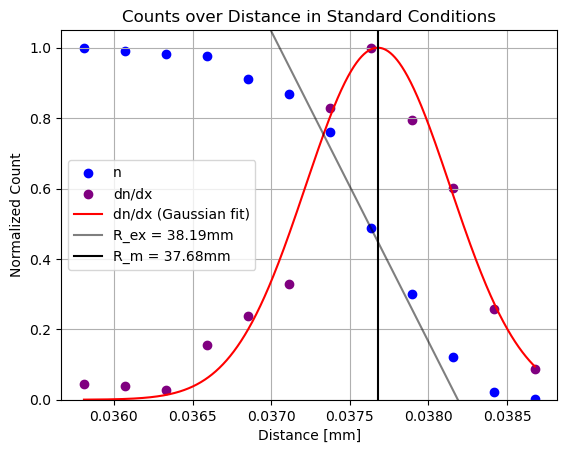

In [78]:
# 5.4 Energy Distribution

#initial_dist_gauss = np.array([np.array([40/1000,1100,200])*10**3,np.array([40/1000,1100,200])*10**3,np.array([40/1000,1000,200])*10**3,np.array([35/1000,1000,200])*10**3,np.array([40/1000,850,200])*10**3,np.array([40/1000,800,200])*10**3,np.array([40/1000,750,200])*10**3,np.array([40/1000,750,200])*10**3,np.array([40/1000,700,200])*10**3,np.array([40/1000,650,200])*10**3])
data_names_sr = ['38,2','38,4','38,6','38,8', '39,0','39,2','39,4','39,6','39,8','40']
distances = np.array([38.2,38.4,38.6,38.8, 39.0,39.2,39.4,39.6,39.8,40])*10**(-3)
data_names_sr = ['39,3','39,6','39,9','40,2', '40,5','40,8','41,1','41,4','41,7','42,0','42,3','42,6']
distances = np.array([39.3, 39.6, 39.9, 40.2, 40.5, 40.8, 41.1, 41.4, 41.7, 42.0, 42.3, 42.6])*10**(-3)
#data_names_sr = ['38,2','38,4','38,6','38,8', '39,0','39,2','39,4','40']
#distances = np.array([38.2,38.4,38.6,38.8, 39.0,39.2,39.4,40])
#data_names_sr = ['38,2','38,4','38,6','38,8', '39,0','39,2','39,4']
#distances = np.array([38.2,38.4,38.6,38.8, 39.0,39.2,39.4])
E_S= 0
def count_find(df,j):
    energy_arr = df[0].to_numpy()  # First column
    energy_arr = calibrate(energy_arr)
    count_arr = df[1].to_numpy()  # Second column
    params, _ = curve_fit(gaussian, energy_arr, count_arr , p0=[np.max(count_arr),energy_arr[np.argmax(count_arr)],0.3e+7])
    amplitude, mean, stddev = params
    fwhm= 2 * np.sqrt(2 * np.log(2)) * np.abs(stddev)
    #print('Peak Volume', amplitude*fwhm)
    #return amplitude
    weighted_mean = np.sum(energy_arr*count_arr)/np.sum(count_arr)
    #return weighted_mean
    #if j == 9: 
        #plt.figure()
        #plt.xlim(0,0.4e6)
        #plt.grid()
        #plt.plot(energy_arr,count_arr)
        #E_S = 0.229e6
        #plt.plot([E_S,E_S],[0,np.max(count_arr)],color = 'black', label = 'E_S')
        #plt.legend
    return np.sum(count_arr)



count_sr = np.zeros(len(data_names_sr))

for j in range(len(data_names_sr)):
    df = pd.read_csv('Data/Distanz variiert/NK-2/' + data_names_sr[j] +'.txt',  sep=r'\s+', header=None)
    count_sr[j] = count_find(df,j)
    
    energy_arr = df[0].to_numpy()  # First column
    energy_arr = calibrate(energy_arr)
    count_arr = df[1].to_numpy()  # Second column

    #plt.figure()
    #plt.xlim(0,2000)
    #plt.plot(energy_arr,count_arr)
    #plt.title(data_names_sr[j])
    
    #plt.plot(energy_arr_cal,count_arr_cal, color = 'black', alpha = 1/(j+1),linewidth=0.5)
    
#print(count_sr)

#plt.figure()
#plt.plot(distances,count_sr * (4 * distances**2 / 3.5**2))
#plt.plot(distances,count_sr)
detector_radius = 3.5*10**-3

#count_sr_geometric = (count_sr / (2 * np.pi * (1 - distances / np.sqrt(distances**2 + detector_radius**2))) )
count_sr_geometric = (count_sr * (2 * np.pi * (1 - 1 / np.sqrt(1 + (detector_radius/(2*distances))**2))) )
count_sr_geometric = (count_sr * distances**2)

normalized =  np.max(count_sr_geometric)
normed_result = count_sr_geometric / normalized
def normed_deriv(result):
    return result/np.max(result)

params, _ = curve_fit(gaussian, distances, -np.gradient(normed_result) , p0=[np.max(normed_result),distances[np.argmax(normed_result)],0.001])
amplitude_der, mean_der, stddev_der = params
fwhm_der= 2 * np.sqrt(2 * np.log(2)) * np.abs(stddev_der)
x_array_der = np.linspace(np.min(distances),np.max(distances),1000) 
gaussian_arr_der = gaussian(x_array_der ,amplitude_der, mean_der, stddev_der)
gradmax = max(-np.gradient(normed_result,distances))
gradmaxloc = np.argmax(-np.gradient(normed_result,distances))
def sloper(x):
    return -gradmax * x + normed_result[gradmaxloc] + gradmax* distances[gradmaxloc]
#print(gradmaxloc)

E_S = 0.229e6

R_S = (3/2)*(E_S/convert_stopping_power(1.464+6.826e-3))
R_ex = -(normed_result[gradmaxloc] + gradmax* distances[gradmaxloc]) / -gradmax




p = 94500
p0 = 101325
T0 = 273.15
T = 20+T0

R_S = R_S*(p/p0)*(T0/T)

def actualx(x):
    p = 94500
    p0 = 101325
    T0 = 273.15
    T = 20+T0
    return x*(p/p0)*(T0/T)+R_S

print('R_S = ', R_S)
print('R_ex = ',actualx(R_ex))
print('R_m = ',actualx(mean_der))

plt.figure()
plt.scatter(actualx(distances), normed_result,color = 'blue',label = 'n')
plt.scatter(actualx(distances), normed_deriv(-np.gradient(normed_result)), color = 'purple',label = 'dn/dx')
plt.plot(actualx(x_array_der) , gaussian_arr_der/np.max(gaussian_arr_der), color = 'red',label = 'dn/dx (Gaussian fit)')
plt.plot(actualx(x_array_der), sloper(x_array_der),color = 'black',alpha = 0.5, label = 'R_ex = 38.19mm')
plt.plot([actualx(mean_der),actualx(mean_der)],[0,2], color = 'black',label = 'R_m = 37.68mm')
plt.xlabel('Distance [mm]') 
plt.title('Counts over Distance in Standard Conditions')
plt.grid()
plt.ylabel('Normalized Count')
plt.legend()
plt.ylim(0,1.05)
plt.savefig('counts.png')


def gammapos(R_ex,R_em):
    return 2.355*(2/np.sqrt(2*np.pi)) * (R_ex - R_em)


gamma_RM = gammapos(actualx(R_ex),actualx(mean_der))
#gamma_R = np.sqrt(gamma_RM**2 - fwhm0**2)

#print(fwhm0)
print('Gamma_RM',gamma_RM)



In [9]:
# 5.3 Foil Thickness

data_names_thick = ['Al27','Al27-3','Au27-7','Co27-5','Cu27-4','Mylar27-8']
data_names_thick_elegant = ['Al-2','Al-3','Au27-7','Co-5','Cu-4','Mylar-8']
index_thick = [0,0,1,2,3,-1]

for j in range(len(data_names_thick)):
    df = pd.read_csv('Data/Foil thickness/'+ data_names_thick[j] +'.txt',  sep=r'\s+', header=None)
    energy_arr = df[0].to_numpy()  # First column
    energy_arr = calibrate(energy_arr)
    count_arr = df[1].to_numpy()  # Second column    
    plt.plot(energy_arr,count_arr,label = data_names_thick_elegant[j])

plt.ylim(0,300)
#plt.plot([mean0,mean0],[-1e+9,1e+9])
plt.legend()
plt.title('Energy Spectrum of Alpha Rays through different Foils')
plt.xlabel('Energy [eV]')
plt.ylabel('Count')
plt.grid()
plt.savefig('foils.png')

import numpy as np

# Material names
materials = ['Al', 'Au', 'Co', 'Cu', 'Fe', 'Ni', 'Si', 'Ti', 'Mumetall', 'Mylar']

# Coefficients arrays [a₂, a₁, a₀] in µm/MeV², µm/MeV, µm
a2 = np.array([0.3796, 0.1025, 0.1466, 0.1420, 0.1599, 0.1379, 0.4231, 0.2782, 0.1423, 0.5894])
a1 = np.array([2.2550, 1.1145, 1.0032, 1.1939, 1.0628, 1.0727, 2.6021, 1.5665, 1.0809, 2.2398])
a0 = np.array([0.7002, 0.2868, 0.4346, 0.5765, 0.4341, 0.4793, 0.5253, 0.4900, 0.4670, 1.1487])

#Coefficients in standard units:
a2 *= 1e-6/1e+12
a1 *= 1e-6/1e+6
a0 *= 1e-6

# Relative uncertainties [%]
rel_uncertainty = np.array([3, 3, 2, 3, 2, 4, 5, 2, 2, 1])/100

a2_err = a2 * rel_uncertainty
a1_err = a1 * rel_uncertainty
a0_err = a0 * rel_uncertainty

def range_poly(E0,E,a2,a1,a0,err):
    return a2*E**2+a1*E+a0
    

def diffR(E0,E,a2,a1,a0,err):
    f = lambda E0, E, a2, a1, a0: a2*E0**2+a1*E0+a0 - (a2*E**2+a1*E+a0)
    result, error = monte_carlo_error(f, [E0,E,a2,a1,a0],err)
    return result, error


def thickness(data_name,index):    
    df = pd.read_csv('Data/Foil thickness/'+ data_name +'.txt',  sep=r'\s+', header=None)
    energy_arr = df[0].to_numpy()  # First column
    energy_arr = calibrate(energy_arr)
    count_arr = df[1].to_numpy()  # Second column
    params, _ = curve_fit(gaussian, energy_arr, count_arr , p0=[np.max(count_arr),energy_arr[np.argmax(count_arr)],0.3e+7])
    amplitude, mean, stddev = params
    stddev = np.abs(stddev)
    fwhm= 2 * np.sqrt(2 * np.log(2)) * np.abs(stddev)
    err = [stddev0,stddev,a2_err[index],a1_err[index],a0_err[index]]
    
    #R_0 = range_poly(mean0,a2[index],a1[index],a0[index],err0)[0]
    #R_t = range_poly(mean,a2[index],a1[index],a0[index],errt)[0]

    return diffR(mean0,mean,a2[index],a1[index],a0[index],err)

    
#initial_thick = np.array([np.array([70/1000,5500,200])*10**7,np.array([300/1000,7500,100])*10**3,np.array([70/1000,6500,500])*10**3,np.array([70/1000,6750,100])*10**3,np.array([20/1000,3400,800])*10**3,np.array([60/1000,4500,200])*10**3])

thickness_arr_poly = np.zeros(len(data_names_thick))
thickness_arr_poly_err = np.zeros(len(data_names_thick))
for j in range(len(data_names_thick)):
    arr_poly =  thickness(data_names_thick[j],index_thick[j])
    thickness_arr_poly[j] = arr_poly[0]
    thickness_arr_poly_err[j] = arr_poly[1]
    

#BLECH THICKNESS

materials = ["Al", "Al", "Au", "Co", "Cu"]

# Material properties from Bethe-Bloch table
I = np.array([176.3, 176.3, 1084.4, 334.7, 385.3])  # Material I [eV]
K = np.array([0.198, 0.198, -1.064, -0.614, -0.540])
Eu_eV = [1.0e6, 1.0e6, 1.5e6, 1.0e6, 1.0e6]  # Eu [eV]
rel_uncertainty = np.array([2, 2, 1, 2, 1])/100  # Relative Uncertainty [%]
atomic_Z = np.array([13, 13, 79, 27, 29])  # Atomic numbers
K_err = K * rel_uncertainty
I_err = I * rel_uncertainty

# Foil properties from Test Site 2 table
rho_g_cm3 = [2.70e-3, 2.70e-3, 19.32e-3, 8.90e-3, 8.92e-3]  # Density [g/cm³]
N_10_22_cm3 = [6.03, 6.03, 5.91, 9.09, 8.45]  # Atomic density [10²² atoms/cm³]

# Converted to standard SI units
rho_kg_m3 = [2700, 2700, 19320, 8900, 8920]  # Density [kg/m³]
N_m3 = np.array([6.03e28, 6.03e28, 5.91e28, 9.09e28, 8.45e28])  # Atomic density [atoms/m³]

m_T = m_alpha
z = 2
N_e = N_m3 * atomic_Z  # In standard units
n = 100 #integration constant

def blech_process_safe(mean0, mean, N_e, K, I):
    """
    Safe version that handles Monte Carlo arrays without vectorized quad
    """
    # Check if we got arrays from Monte Carlo
    if hasattr(mean0, '__len__'):
        n_samples = len(mean0)
        results = np.zeros(n_samples)
        
        # Process each Monte Carlo sample individually
        for sample_idx in range(n_samples):
            # Extract scalar values for this sample
            m0 = mean0[sample_idx]
            m = mean[sample_idx] 
            n_e = N_e[sample_idx]
            k_val = K[sample_idx]
            i_val = I[sample_idx]
            
            # Now do scalar integration for this sample
            dE = m0 - m
            dE_step = dE / (n - 1)
            
            thickness_total = 0
            integrand = lambda x: 1 / stopping(n_e, k_val, i_val, x)
            
            for j in range(n):
                lower = m + dE_step * j
                upper = m + dE_step * (j + 1)
                thickness_total += integrate.quad(integrand, lower, upper)[0]
            
            results[sample_idx] = thickness_total
        
        return results
        
    else:
        # Scalar inputs (original code)
        dE = mean0 - mean
        dE_step = dE / (n - 1)
        
        thickness_total = 0
        integrand = lambda x: 1 / stopping(N_e, K, I, x)
        
        for j in range(n):
            lower = mean + dE_step * j
            upper = mean + dE_step * (j + 1)
            thickness_total += integrate.quad(integrand, lower, upper)[0]
        
        return thickness_total

def blech_process(mean0,mean,N_e,K,I):
    dE = mean0 - mean
    dE_step = (mean0-mean)/(n-1)
    
    thickness_arr = np.zeros(n)
    integrand = lambda x: 1/stopping(N_e,K,I,x)

    #x = np.linspace(0,1.5e+7,1000)
    #plt.figure()
    #plt.plot(x,stopping(N_e,K,I,x))
    
    for j in range(n):
        thickness_arr[j] = integrate.quad(integrand,mean+dE_step*(j),mean+dE_step*(j+1))[0]

    return np.sum(thickness_arr)

def blech_thickness(data_name,N_e,K,I,K_err,I_err):   
    df = pd.read_csv('Data/Foil thickness/'+ data_name +'.txt',  sep=r'\s+', header=None)
    energy_arr = df[0].to_numpy()  # First column
    energy_arr = calibrate(energy_arr)
    count_arr = df[1].to_numpy()  # Second column
    params, _ = curve_fit(gaussian, energy_arr, count_arr , p0=[np.max(count_arr),energy_arr[np.argmax(count_arr)],0.3e+7])
    amplitude, mean, stddev = params
    fwhm= 2 * np.sqrt(2 * np.log(2)) * np.abs(stddev)

    err= [np.abs(stddev0),np.abs(stddev),0.00001,np.abs(K_err),np.abs(I_err)]
    
    result, err = monte_carlo_error(blech_process_safe, [mean0,mean,N_e,K,I],err)
    return result, err
    

thickness_arr_blech = np.zeros(len(materials))
thickness_arr_blech_err = np.zeros(len(materials))
for j in range(len(materials)):
    blech_thick =  blech_thickness(data_names_thick[j],N_e[j],K[j],I[j],K_err[j],I_err[j])
    thickness_arr_blech[j] = blech_thick[0]
    thickness_arr_blech_err[j] = blech_thick[1]


 
print('Name',data_names_thick)
print('Polynomial Thickness',thickness_arr_poly)
print('Polynomial Thickness Error',thickness_arr_poly_err)
print('Bethe-Bloch Thickness',thickness_arr_blech)
print('Bethe-Bloch Thickness',thickness_arr_blech_err)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001DA7C58B920> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

-dEdx max 459036030.55288756
Maximum Energy 1678107.2431947559
Position of Max. Energy 0.03271220665203444


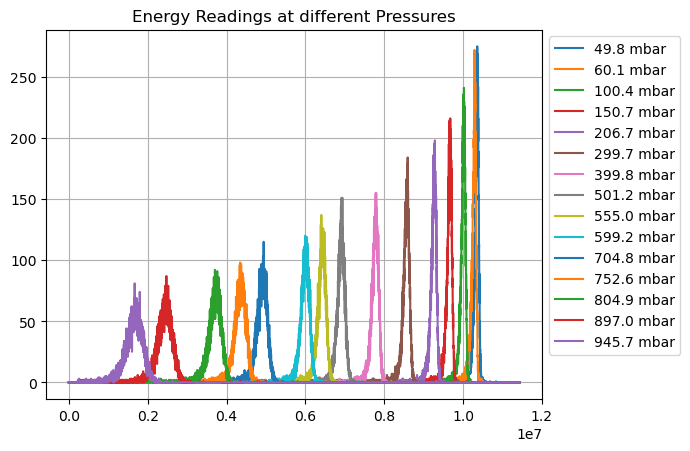

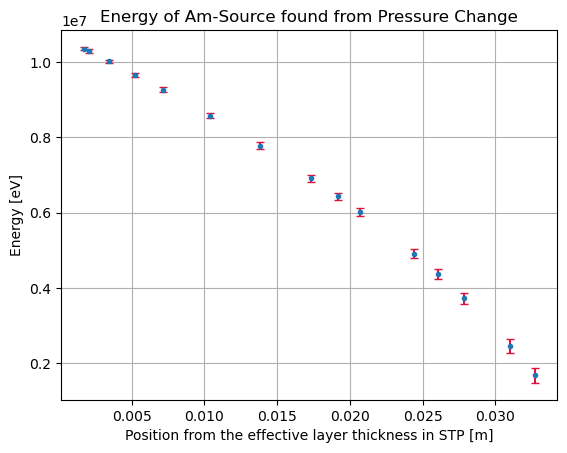

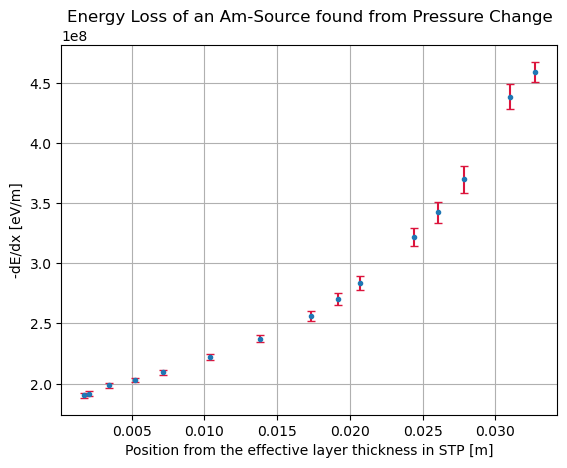

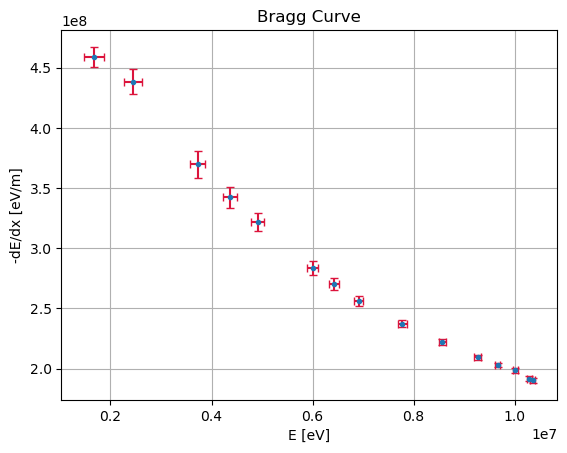

In [14]:
# 5.5 SPECIFIC ENERGY LOSS

data_names_loss = ["49,8mbar_d38mm.txt","60,1mbar_d38mm.txt","100,4mbar_d38mm.txt","150,7mbar_d38mm.txt","206,7mbar_d38mm.txt","299,7mbar_d38mm.txt","399,8mbar_d38mm.txt","501,2mbar_d38mm.txt","555,0mbar_d38mm.txt","599,2mbar_d38mm.txt","704,8mbar_d38mm.txt","752,6mbar_d38mm.txt","804,9mbar_d38mm.txt","897,0mbar_d38mm.txt","945,7mbar_d38mm.txt"]
data_names_loss_pretty = ["49.8 mbar", "60.1 mbar", "100.4 mbar", "150.7 mbar", "206.7 mbar", 
                         "299.7 mbar", "399.8 mbar", "501.2 mbar", "555.0 mbar", "599.2 mbar", 
                         "704.8 mbar", "752.6 mbar", "804.9 mbar", "897.0 mbar", "945.7 mbar"]

pascal_values = np.array([4980.0, 6010.0, 10040.0, 15070.0, 20670.0, 29970.0, 39980.0, 50120.0, 55500.0, 59920.0, 70480.0, 75260.0, 80490.0, 89700.0, 94570.0]) #pascal


loss_E_arr = np.zeros(len(data_names_loss))
loss_E_Omegab = np.zeros(len(data_names_loss))

plt.figure()
plt.title('Energy Readings at different Pressures')
for j in range(len(data_names_loss)):
    df = pd.read_csv('Data/Druck variert/'+ data_names_loss[j],  sep=r'\s+', header=None)
    energy_arr = df[0].to_numpy()  # First column
    energy_arr = calibrate(energy_arr)
    count_arr = df[1].to_numpy()  # Second column

    params, _ = curve_fit(gaussian, energy_arr, count_arr , p0=[np.max(count_arr),energy_arr[np.argmax(count_arr)],0.05e+7])
    amplitude, mean, stddev = params
    fwhm= 2 * np.sqrt(2 * np.log(2)) * np.abs(stddev)
    
    plt.plot(energy_arr,count_arr,label = data_names_loss_pretty[j])

    #plt.plot(energy_arr, gaussian(energy_arr, amplitude, mean, stddev), color = 'black')

    loss_E_arr[j] = mean
    loss_E_Omegab[j] = np.abs(stddev)

#plt.ylim(0,450)
#plt.xlim(0,1.1e+7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Right side

plt.grid()
plt.savefig('pressure_changes.png')

#plt.figure()
#plt.title('Pressure')
#plt.plot(pascal_values,loss_E_arr)

T_0 = 273.15
p_0 = 1013.25*100
x_0 = 38e-3

def ptox(p):
    return x_0 * p * T_0 / (p_0 * T)

positions = ptox(pascal_values)


plt.figure()
plt.title('Energy of Am-Source found from Pressure Change')
plt.xlabel('Position from the effective layer thickness in STP [m]')
plt.ylabel('Energy [eV]')
plt.grid()
plt.errorbar(ptox(pascal_values),loss_E_arr, yerr = loss_E_Omegab,ecolor = 'crimson', fmt='.', capsize=3)
plt.savefig('last.png')

#Derivative

def gradient_with_error(E, x, E_err, x_err):   
    dEdx = np.zeros(len(loss_E_arr))
    dE_dx_error = np.zeros(len(loss_E_arr))
    
    
    dEdx = np.gradient(E,x)
    error = np.sqrt((np.gradient(dEdx,x)*x_err)**2 + (np.gradient(dEdx,E)*E_err)**2)
    
    return dEdx, error






dEdx, dE_dx_error = gradient_with_error(loss_E_arr, positions, loss_E_Omegab, 0.5e-3)


plt.figure()

plt.title('Energy Loss of an Am-Source found from Pressure Change')

#plt.plot(positions,dEdx)
plt.xlabel('Position from the effective layer thickness in STP [m]')
plt.ylabel('-dE/dx [eV/m]')
plt.errorbar(positions, -dEdx, yerr=dE_dx_error,ecolor = 'crimson', fmt='.', capsize=3)
print('-dEdx max', np.max(-dEdx))
print('Maximum Energy', loss_E_arr[np.argmax(-dEdx)])
print('Position of Max. Energy', ptox(pascal_values)[np.argmax(-dEdx)])

plt.grid()
plt.savefig('lastder.png')


plt.figure()

plt.title('Bragg Curve')

#plt.plot(positions,dEdx)
plt.xlabel('E [eV]')
plt.ylabel('-dE/dx [eV/m]')
plt.errorbar(loss_E_arr, -dEdx, yerr=dE_dx_error,ecolor = 'crimson', xerr = loss_E_Omegab, fmt='.', capsize=3)
plt.grid()
plt.savefig('lastbragg.png')




83676.2295747675


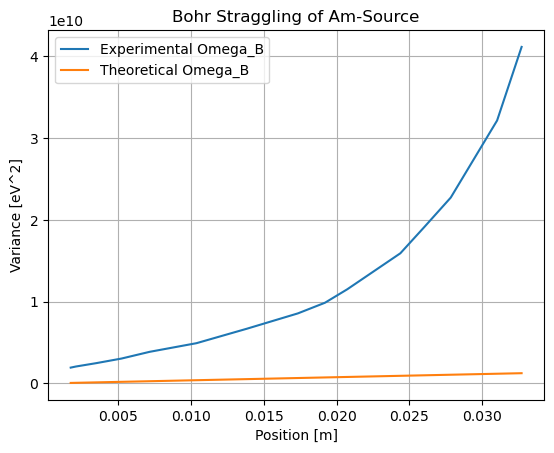

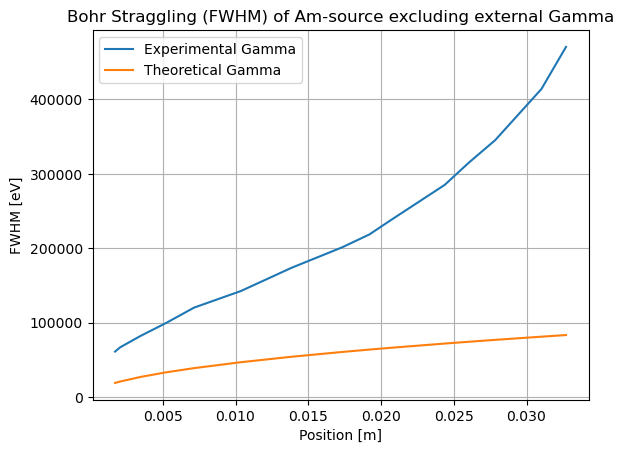

In [15]:
#Straggling 

def bohrstraggling(x):
    return 4 * np.pi * 2**2 * epsilon_squared ** 2 * N_e_air * x

plt.figure()
plt.title('Bohr Straggling of Am-Source')
plt.xlabel('Position [m]')
plt.ylabel('Variance [eV^2]')
plt.plot(positions,loss_E_Omegab**2,label = 'Experimental Omega_B')
plt.plot(positions,bohrstraggling(positions),label = 'Theoretical Omega_B')
plt.legend()
plt.grid()
plt.savefig('lastbohr.png')



gamma_exp = 2 * np.sqrt(2 * np.log(2)) * np.abs(loss_E_Omegab)
gamma0 = fwhm0
print(gamma0)
gamma = np.sqrt(gamma_exp**2 - gamma0**2)

plt.figure()
plt.title('Bohr Straggling (FWHM) of Am-source excluding external Gamma')
plt.xlabel('Position [m]')
plt.ylabel('FWHM [eV]')
plt.plot(positions,  gamma,label = 'Experimental Gamma')
plt.plot(positions,2 * np.sqrt(2 * np.log(2)) * np.sqrt(bohrstraggling(positions)),label = 'Theoretical Gamma')
plt.legend()
plt.grid()
plt.savefig('lastbohrfwhm.png')